### Import packages

In [308]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

## I. Dataset exploration

In [309]:
# Importing all files as dataframes
code_df = pd.read_csv('data/codes.csv', delimiter=';')
transactions_df=pd.read_csv('data/transactions.csv', sep=';')
train_df=pd.read_csv('data/train_set.csv', sep=';', encoding = "ISO-8859-1")
test_df=pd.read_csv('data/test_set.csv', encoding = "ISO-8859-1")
types_df = pd.read_csv('data/types.csv', delimiter=';')

Merge other tables to our main transactions_df:

In [310]:
#transactions_df=transactions_df.merge(types_df,  how='left',on="type")
#transactions_df=transactions_df.merge(code_df,  how='left',on="code")
transactions_df=transactions_df.merge(train_df,  how='left',on="client_id")

Remove rows without class because they are useless for learning:

In [311]:
print(f'Rows to be removed : {transactions_df.isnull()["target"].sum()}')
transactions_df.dropna(inplace=True)

Rows to be removed : 38213


After merge of train set, client_id is now useless, removing:

In [312]:
transactions_df.drop(["client_id"],axis=1, inplace=True)
transactions_df.head()

,datetime,code,type,sum,target
0,421 06:33:15,6011,2010,-561478.94,0.0
2,55 13:38:47,6011,2010,-44918.32,0.0
4,151 10:34:12,4814,1030,-3368.87,0.0
5,398 00:00:00,5411,1110,-1572.14,0.0
6,423 15:27:55,6010,7070,5654.99,1.0


## II. Explanatory data analysis

In [313]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91826 entries, 0 to 130038
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  91826 non-null  object 
 1   code      91826 non-null  int64  
 2   type      91826 non-null  int64  
 3   sum       91826 non-null  float64
 4   target    91826 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 4.2+ MB


In [314]:
transactions_df.describe()

,code,type,sum,target
count,91826.000000,91826.000000,9.182600e+04,91826.000000
mean,5596.441389,2549.483403,-1.666997e+04,0.491266
std,602.144814,2295.581132,6.232297e+05,0.499926
min,742.000000,1010.000000,-4.150030e+07,0.000000
25%,5251.000000,1030.000000,-2.156079e+04,0.000000
50%,5661.000000,1110.000000,-5.239160e+03,0.000000
75%,6010.000000,2370.000000,-1.122960e+03,1.000000
max,9402.000000,8145.000000,6.737747e+07,1.000000


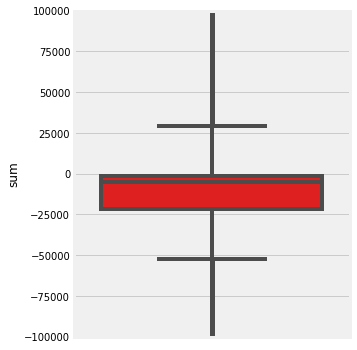

In [315]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.ylim(-100000, 100000)
sns.boxplot(y=transactions_df['sum'], color="red")
plt.show()

## III. Feature engineering


Making continues values from code, type columns

In [316]:
codes = {transactions_df.code.unique()[i]:i for i in range(0, len(transactions_df.code.unique()))}
transactions_df['code'] = [codes[x] for x in transactions_df['code']]
types = {transactions_df.type.unique()[i]:i for i in range(0, len(transactions_df.type.unique()))}
transactions_df['type'] = [types[x] for x in transactions_df['type']]

Making features from datetime column

In [317]:
transactions_df['day'] = [int(x.split(' ')[0]) for x in transactions_df['datetime']]
time_str = [x.split(' ')[1] for x in transactions_df['datetime']]
time = [(int(x.split(':')[0]), int(x.split(':')[1]), int(x.split(':')[2])) for x in time_str]
transactions_df['seconds'] = [x[0]*3600+x[1]*60+x[2] for x in time]

Removing old datetime column

In [318]:
transactions_df.drop(["datetime"],axis=1, inplace=True)
transactions_df.head()

,code,type,sum,target,day,seconds
0,0,0,-561478.94,0.0,421,23595
2,0,0,-44918.32,0.0,55,49127
4,1,1,-3368.87,0.0,151,38052
5,2,2,-1572.14,0.0,398,0
6,3,3,5654.99,1.0,423,55675


## IV. Supervised learning
Divide dataset feature/class and train/test:

In [319]:
X = transactions_df.drop(["target"],axis=1)
y = transactions_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2005, test_size=0.2)

### Decision tree
#### Finding best depth
Calculate cross validation scores for each depth from 1 to 20:

In [320]:
cv_scores_list = []
cv_scores_std = []
cv_scores_mean = []
accuracy_scores = []
for depth in range(1,20):
    tree_model = DecisionTreeClassifier(max_depth=depth)
    cv_scores = cross_val_score(tree_model, X, y, cv=5, scoring='accuracy')
    cv_scores_list.append(cv_scores)
    cv_scores_mean.append(cv_scores.mean())
    cv_scores_std.append(cv_scores.std())
    accuracy_scores.append(tree_model.fit(X, y).score(X, y))
cv_scores_mean = np.array(cv_scores_mean)
cv_scores_std = np.array(cv_scores_std)
accuracy_scores = np.array(accuracy_scores)


Draw graph of validation scores:

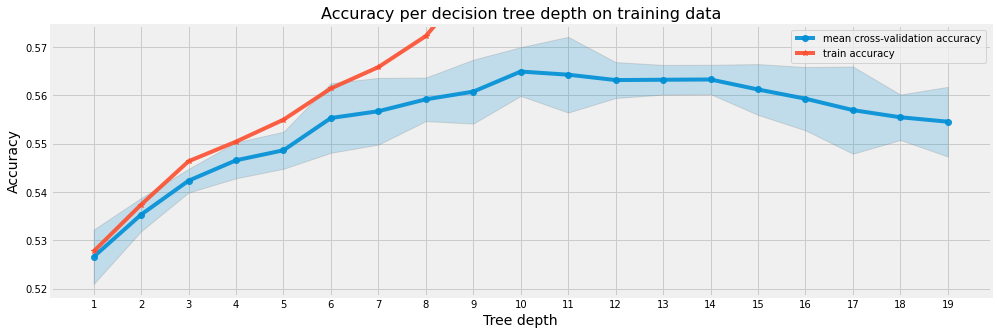

In [321]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(range(1,20), cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
ax.fill_between(range(1,20), cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
ylim = plt.ylim()
ax.plot(range(1,20), accuracy_scores, '-*', label='train accuracy', alpha=0.9)
ax.set_title('Accuracy per decision tree depth on training data', fontsize=16)
ax.set_xlabel('Tree depth', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(ylim)
ax.set_xticks(range(1,20))
ax.legend()

Selecting best spot:

In [322]:
idx_max = cv_scores_mean.argmax()
sm_best_tree_depth = range(1,20)[idx_max]
sm_best_tree_cv_score = cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = cv_scores_std[idx_max]
print(f'Best Depth = {sm_best_tree_depth}\n'
      f'Cross validation accuracy = {round(sm_best_tree_cv_score*100,2)} '
      f'+/- {round(sm_best_tree_cv_score_std*100, 2)}%')

Best Depth = 10
Cross validation accuracy = 56.49 +/- 0.25%


Running decision tree with previous depth:

[Text(0.4618504213483146, 0.9545454545454546, 'seconds <= 20350.0\ngini = 0.5\nsamples = 73460\nvalue = [37435, 36025]'),
 Text(0.2618679775280899, 0.8636363636363636, 'sum <= 1325.09\ngini = 0.494\nsamples = 12217\nvalue = [5463, 6754]'),
 Text(0.16529143258426968, 0.7727272727272727, 'sum <= -1234.13\ngini = 0.498\nsamples = 10841\nvalue = [5080, 5761]'),
 Text(0.08672752808988764, 0.6818181818181818, 'seconds <= 9477.0\ngini = 0.496\nsamples = 9901\nvalue = [4504, 5397]'),
 Text(0.0375, 0.5909090909090909, 'code <= 4.5\ngini = 0.493\nsamples = 8536\nvalue = [3775, 4761]'),
 Text(0.015870786516853932, 0.5, 'type <= 0.5\ngini = 0.499\nsamples = 3179\nvalue = [1513, 1666]'),
 Text(0.006741573033707865, 0.4090909090909091, 'day <= 434.0\ngini = 0.399\nsamples = 98\nvalue = [27, 71]'),
 Text(0.0056179775280898875, 0.3181818181818182, 'day <= 381.0\ngini = 0.385\nsamples = 96\nvalue = [25, 71]'),
 Text(0.0044943820224719105, 0.22727272727272727, 'seconds <= 854.5\ngini = 0.415\nsamples = 

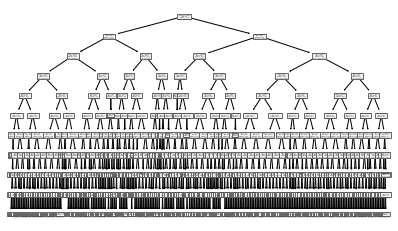

In [323]:
model = DecisionTreeClassifier(max_depth=sm_best_tree_depth)
model = model.fit(X_train, y_train)
dec_tree_predict = model.predict(X_test)
plot_tree(model, feature_names = X.columns)

### Random forest:


In [324]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)
rand_forest_predict = rf.predict(X_test)

## V. Results
### Decision tree:

In [325]:
print(f'Precision score = {precision_score(y_test, dec_tree_predict)}\n'
      f'Recall score = {recall_score(y_test, rand_forest_predict)}\n'
      f'r^2 score = {r2_score(y_test, dec_tree_predict)}\n'
      f'Train accuracy = {model.score(X_train, y_train)}\n'
      f'Test accuracy = {model.score(X_test, y_test)}')

Precision score = 0.5886792452830188
Recall score = 0.5231124807395994
r^2 score = -0.7026837186045978
Train accuracy = 0.5926490607133134
Test accuracy = 0.5743765653925732


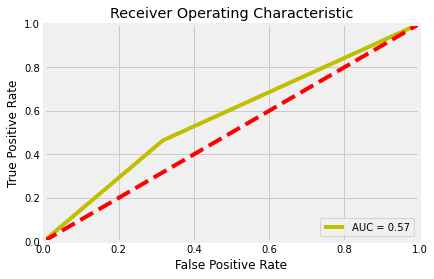

In [326]:
fpr, tpr, thresholds = roc_curve(y_test, dec_tree_predict)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'y', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random forest:

In [327]:
print(f'Precision score = {precision_score(y_test, rand_forest_predict)}\n'
      f'Recall score = {recall_score(y_test, rand_forest_predict)}\n'
      f'r^2 score = {r2_score(y_test, rand_forest_predict)}\n'
      f'Train accuracy = {model.score(X_train, y_train)}\n'
      f'Test accuracy = {model.score(X_test, y_test)}')

Precision score = 0.5658333333333333
Recall score = 0.5231124807395994
r^2 score = -0.7381880612082243
Train accuracy = 0.5926490607133134
Test accuracy = 0.5743765653925732


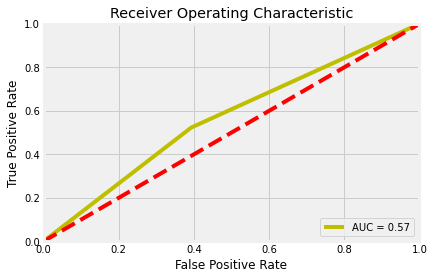

In [328]:
fpr, tpr, thresholds = roc_curve(y_test, rand_forest_predict)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'y', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## VI. Conclusion

Decision tree with tuned hyper parameters got better accuracy, than Random Forest. Although, as we can see from r2 scores, input data is not very efficient for calculation gender.